In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load the Dataset ---

In [2]:
# Read the data that is inside of the CSV
df = pd.read_csv("./Health_Data/cleaned_health.csv")
df

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,cp_0,cp_1,cp_2,cp_3
0,52,1,125,212,0,1,168,0,1.0,2,2,3,0,1,0,0,0
1,53,1,140,203,1,0,155,1,3.1,0,0,3,0,1,0,0,0
2,70,1,145,174,0,1,125,1,2.6,0,0,3,0,1,0,0,0
3,61,1,148,203,0,1,161,0,0.0,2,1,3,0,1,0,0,0
4,62,0,138,294,1,1,106,0,1.9,1,3,2,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,68,0,120,211,0,0,115,0,1.5,1,0,2,1,0,0,1,0
298,44,0,108,141,0,1,175,0,0.6,1,0,2,1,0,0,1,0
299,52,1,128,255,0,1,161,1,0.0,2,1,3,0,1,0,0,0
300,59,1,160,273,0,0,125,0,0.0,2,0,2,0,0,0,0,1


In [3]:
# Define features (X) and target (y) columns
# These are the columns from your dataset that will be used for training
FEATURES = [
    'age', 'sex', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
    'exang', 'oldpeak', 'slope', 'ca', 'thal',
    'cp_0', 'cp_1', 'cp_2', 'cp_3'
]
TARGET_COL = 'target' # The column indicating disease presence (0 or 1)
NUMERICAL_COLS = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

# --- 2. Data Preprocessing (Ensuring Cleanliness and Correct Types) ---

In [4]:
print("\n--- Data Preprocessing ---")

# Handle '?' or other non-numeric values if they exist, converting to NaN first
df.replace('?', np.nan, inplace=True)
df.replace('N/A', np.nan, inplace=True)

# Convert all feature and target columns to numeric, coercing errors
all_relevant_cols = FEATURES + [TARGET_COL]
for col in all_relevant_cols:
    if col in df.columns:
        # For numerical columns, use float type initially to handle NaNs, then convert to Int64 if appropriate
        if col in ['sex', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal', 'cp_0', 'cp_1', 'cp_2', 'cp_3', TARGET_COL]:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64') # Use nullable integer
        else:
            df[col] = pd.to_numeric(df[col], errors='coerce')

# Impute missing values after type conversion
print("Missing values before imputation for modeling:")
print(df[all_relevant_cols].isnull().sum()[df[all_relevant_cols].isnull().sum() > 0])

for col in all_relevant_cols:
    if col in df.columns and df[col].isnull().any():
        if pd.api.types.is_numeric_dtype(df[col]):
            # Use median for numerical features, mode for categorical/target
            if col in NUMERICAL_COLS: # Assuming NUMERICAL_COLS is defined from EDA script
                median_val = df[col].median()
                df[col].fillna(median_val, inplace=True)
                print(f"Filled missing values in '{col}' with its median ({median_val}).")
            else: # Categorical/binary features including target
                mode_val = df[col].mode()[0]
                df[col].fillna(mode_val, inplace=True)
                print(f"Filled missing values in '{col}' with its mode ({mode_val}).")
        else:
            # Fallback for non-numeric (shouldn't happen if type conversion is robust)
            mode_val = df[col].mode()[0]
            df[col].fillna(mode_val, inplace=True)
            print(f"Filled missing non-numeric values in '{col}' with its mode ({mode_val}).")

print("\nMissing values after imputation for modeling:")
print(df[all_relevant_cols].isnull().sum())

# Separate features (X) and target (y)
X = df[FEATURES]
y = df[TARGET_COL]

# Check if target variable has only two unique values (binary classification)
if y.nunique() != 2:
    print(f"Error: The target column '{TARGET_COL}' is not binary. It has {y.nunique()} unique values: {y.unique()}")
    print("Please ensure your 'target' column is binary (e.g., 0 and 1) for classification.")
    exit()

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print(f"Target distribution:\n{y.value_counts(normalize=True).round(2)}")


--- Data Preprocessing ---
Missing values before imputation for modeling:
Series([], dtype: int64)

Missing values after imputation for modeling:
age         0
sex         0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
cp_0        0
cp_1        0
cp_2        0
cp_3        0
target      0
dtype: int64

Features (X) shape: (302, 16)
Target (y) shape: (302,)
Target distribution:
1    0.54
0    0.46
Name: target, dtype: Float64


# --- 3. Split Data into Training and Testing Sets ---

In [5]:
# We use a stratified split to ensure that the proportion of target classes
# is roughly the same in both training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print(f"\nTraining set shape: {X_train.shape}, {y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {y_test.shape}")


Training set shape: (226, 16), (226,)
Testing set shape: (76, 16), (76,)


# --- 4. Feature Scaling (for numerical features) ---

In [6]:
# Scaling is crucial for algorithms sensitive to feature magnitudes (e.g., Logistic Regression, SVM, Neural Networks)
# Tree-based models (Random Forest) are generally not sensitive to scaling.
print("\n--- Feature Scaling ---")
scaler = StandardScaler()

# Identify numerical features that are actually present in the DataFrame
numerical_features_in_X = [col for col in NUMERICAL_COLS if col in X_train.columns]

if numerical_features_in_X:
    X_train[numerical_features_in_X] = scaler.fit_transform(X_train[numerical_features_in_X])
    X_test[numerical_features_in_X] = scaler.transform(X_test[numerical_features_in_X])
    print(f"Scaled numerical features: {numerical_features_in_X}")
else:
    print("No numerical features found for scaling.")

print("\nFirst 5 rows of scaled training features:")
print(X_train.head())


--- Feature Scaling ---
Scaled numerical features: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

First 5 rows of scaled training features:
         age  sex  trestbps      chol  fbs  restecg   thalach  exang  \
18  0.410557    1  0.515901 -0.676764    1        0  0.611286      0   
90 -0.246722    1 -0.804933 -1.153240    0        0  1.717907      0   
75 -1.123095    1 -0.684857 -0.505233    0        1  0.832610      0   
8  -0.904002    1 -0.684857  0.047479    0        0 -0.318276      0   
28  0.081918    0  2.917417  1.534084    0        2 -1.513427      1   

     oldpeak  slope  ca  thal  cp_0  cp_1  cp_2  cp_3  
18 -0.851400      2   0     2     0     0     1     0  
90 -0.851400      1   0     1     0     0     0     1  
75 -0.851400      2   0     2     0     1     0     0  
8  -0.149150      2   0     3     1     0     0     0  
28  2.133161      1   0     2     1     0     0     0  


# --- 5. Model Training and Evaluation ---

# --- 5.1. Logistic Regression ---

In [7]:
print("\n--- Training and Evaluating Logistic Regression Model ---")
log_reg_model = LogisticRegression(random_state=42, solver='liblinear') # liblinear is good for small datasets
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_test)
y_proba_log_reg = log_reg_model.predict_proba(X_test)[:, 1] # Probability of target=1

print("\nLogistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_log_reg):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_log_reg):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_log_reg):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_log_reg):.4f}")
print("\nConfusion Matrix (Logistic Regression):")
print(confusion_matrix(y_test, y_pred_log_reg))
print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_log_reg))


--- Training and Evaluating Logistic Regression Model ---

Logistic Regression Performance:
Accuracy: 0.7500
Precision: 0.7750
Recall: 0.7561
F1-Score: 0.7654
ROC AUC Score: 0.8732

Confusion Matrix (Logistic Regression):
[[26  9]
 [10 31]]

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

         0.0       0.72      0.74      0.73        35
         1.0       0.78      0.76      0.77        41

    accuracy                           0.75        76
   macro avg       0.75      0.75      0.75        76
weighted avg       0.75      0.75      0.75        76



# --- 5.2. Random Forest Classifier ---

In [8]:
print("\n--- Training and Evaluating Random Forest Classifier Model ---")
# RandomForestClassifier is a robust ensemble method
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # class_weight helps with imbalance
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1] # Probability of target=1

print("\nRandom Forest Classifier Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_rf):.4f}")
print("\nConfusion Matrix (Random Forest):")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))


--- Training and Evaluating Random Forest Classifier Model ---

Random Forest Classifier Performance:
Accuracy: 0.7632
Precision: 0.7805
Recall: 0.7805
F1-Score: 0.7805
ROC AUC Score: 0.8422

Confusion Matrix (Random Forest):
[[26  9]
 [ 9 32]]

Classification Report (Random Forest):
              precision    recall  f1-score   support

         0.0       0.74      0.74      0.74        35
         1.0       0.78      0.78      0.78        41

    accuracy                           0.76        76
   macro avg       0.76      0.76      0.76        76
weighted avg       0.76      0.76      0.76        76



# --- 6. Feature Importance (for Random Forest) ---


--- Feature Importance from Random Forest Model ---
cp_0        0.153959
oldpeak     0.115998
thalach     0.113478
ca          0.104462
thal        0.086284
age         0.084936
trestbps    0.065353
chol        0.064406
exang       0.055436
sex         0.037566
slope       0.036197
cp_2        0.023784
restecg     0.022339
cp_1        0.014097
cp_3        0.012004
fbs         0.009700
dtype: float64


C:\Users\lualg\AppData\Local\Temp\ipykernel_34288\323484264.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')


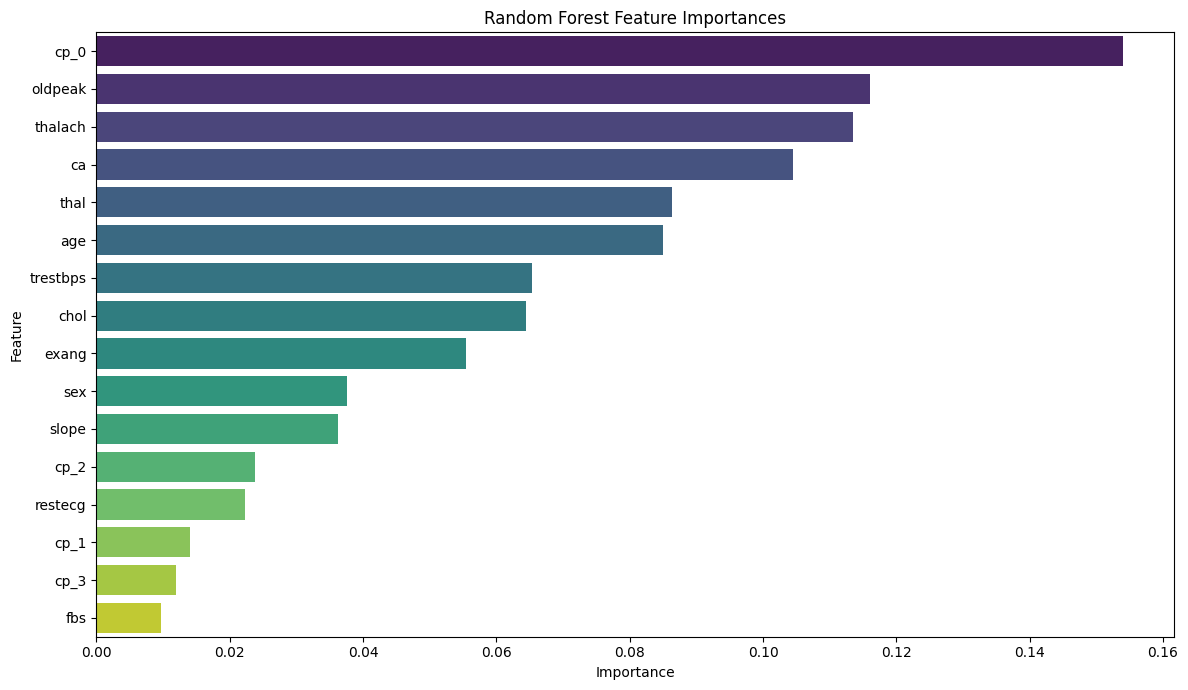

In [9]:
print("\n--- Feature Importance from Random Forest Model ---")
if hasattr(rf_model, 'feature_importances_'):
    feature_importances = pd.Series(rf_model.feature_importances_, index=FEATURES).sort_values(ascending=False)
    print(feature_importances)

    plt.figure(figsize=(12, 7))
    sns.barplot(x=feature_importances, y=feature_importances.index, palette='viridis')
    plt.title('Random Forest Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()
else:
    print("Feature importances not available for this model type.")

In [10]:
print("\nPredictive modeling and evaluation complete.")


Predictive modeling and evaluation complete.
